**Sources:**
- Datase available https://www.kaggle.com/datasets/pascalbliem/handwritten-chinese-character-hanzi-datasets
- Data input and resizing code partially modified from https://www.kaggle.com/code/huanghaicheng1024/preprocessing-of-data
- CNN code modified from https://github.com/davidmascharka/MyNN
- Code for progress bar (for epoch) from https://stackoverflow.com/a/41457700

In [1]:
from PIL import Image, ImageEnhance
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import re

np.random.seed(1024)

# CNN imports
from mynn.layers.conv import conv
from mynn.layers.dense import dense
from mygrad.nnet.activations.relu import relu
from mynn.losses.cross_entropy import softmax_cross_entropy
from mygrad.nnet.initializers.glorot_uniform import glorot_uniform
from mynn.optimizers.sgd import SGD

from mygrad.nnet.layers.pooling import max_pool

%matplotlib notebook

In [2]:
#train_path = r"C:\Users\nrabi\Documents\ChineseChars\labeled_data\train_init"
train_path = r"C:\Users\nrabi\Documents\ChineseChars\labeled_data\After-train_4char"
#train_path = r"C:\Users\nrabi\Documents\ChineseChars\labeled_data\my3chartrain"

#test_path = r"C:\Users\nrabi\Documents\ChineseChars\labeled_data\test"
test_path = r"C:\Users\nrabi\Documents\ChineseChars\labeled_data\After-test_4char"
#test_path = r"C:\Users\nrabi\Documents\ChineseChars\labeled_data\my3chartest"

train_chinese = os.listdir(train_path)
test_chinese = os.listdir(test_path)
print(len(train_chinese))
print(len(test_chinese))
print(train_chinese)
print(test_chinese)

10
10
['口', '如', '慷', '欢', '正', '每', '毕', '毡', '爪', '讧']
['口', '如', '慷', '欢', '正', '每', '毕', '毡', '爪', '讧']


In [3]:
# Characters to be included

chinese = "如口毕爪" #正每慷欢毡讧每

print(len(chinese))

4


In [4]:
# Uses pandas for the temporary data storage
df_train = pd.DataFrame(columns=["chinese","filename"])
for i in chinese:
    l = os.listdir(train_path+'/'+i)
    df_train = df_train.append(pd.DataFrame({
        "chinese":i,
        "filename":l
    }),ignore_index = True)
    
df_train.shape
#print(df_train)

C:\Users\nrabi\AppData\Local\Temp\ipykernel_25148\625129597.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(pd.DataFrame({


(2233, 2)

In [5]:
print(df_train, "\n\n")
# Updates the filename to include 口/1.png instead of only 1.png
df_train["filename"] = df_train['chinese']+"/"+df_train["filename"]
df_train.head()

     chinese filename
0          如    1.png
1          如   10.png
2          如  100.png
3          如  101.png
4          如  102.png
...      ...      ...
2228       爪   95.png
2229       爪   96.png
2230       爪   97.png
2231       爪   98.png
2232       爪   99.png

[2233 rows x 2 columns] 




,chinese,filename
0,如,如/1.png
1,如,如/10.png
2,如,如/100.png
3,如,如/101.png
4,如,如/102.png


In [6]:
def img_map(image):
    image = image.convert('L') # convert to grayscale
    image = image.resize((28,28), Image.ANTIALIAS) # rescale image to 28 x 28
    
    enh_col = ImageEnhance.Contrast(image) # increase contrast
    factor = np.random.uniform(2,3,1)
    image = enh_col.enhance(factor=factor)
    
    return image

def to_array(image):
    return np.array(image)

def img_rotate_CCW(image): # rotate image ccw
    r = np.random.uniform(1,3,1)
    return image.rotate(r, fillcolor="white")

def img_rotate_CW(image): # rotate image cw
    r = np.random.uniform(1,3,1)
    return image.rotate(360-r, fillcolor="white")

In [7]:
def img_trans(imgs, direction):
    s = imgs.shape
    img1 = np.zeros(shape=s)+255
    px = np.random.choice([1,2,3],1)[0]
    if direction == "left":
        img1[:,:,:s[2]-px] = imgs[:,:,px:]
    if direction == "right":
        img1[:,:,px:] = imgs[:,:,:s[2]-px]
    if direction == "up":
        img1[:,:s[1]-px,:] = imgs[:,px:,:]
    if direction == "down":
        img1[:,px:,:] = imgs[:,:s[1]-px,:]
    return img1

In [8]:
train_images = map(Image.open,train_path+"/"+df_train["filename"])

train_img = list(map(img_map,train_images))

train_images_CW = map(img_rotate_CW,train_img)
train_images_CCW = map(img_rotate_CCW,train_img) 

train_images_CW = map(to_array,train_images_CW)
train_images_CCW = map(to_array,train_images_CCW)
train_images = map(to_array,train_img)

train_images_CW = np.array(list(train_images_CW))
train_images_CCW = np.array(list(train_images_CCW))
train_images = np.array(list(train_images))

print(train_images.shape,train_images_CW.shape,train_images_CCW.shape)

(2233, 28, 28) (2233, 28, 28) (2233, 28, 28)


In [9]:
train_images_left  = img_trans(train_images,"left")
train_images_right = img_trans(train_images,"right")
train_images_up    = img_trans(train_images,"up")
train_images_down  = img_trans(train_images,"down")

In [10]:
train_images = np.concatenate((train_images,train_images_left,
                               train_images_right,train_images_up,
                               train_images_down,train_images_CW,
                              train_images_CCW))
x = np.array(df_train["chinese"])
df1 = pd.DataFrame(columns=["chinese"])
y_train = np.tile(x,7)
print(train_images.shape,y_train.shape)

(15631, 28, 28) (15631,)


In [11]:
df_test = pd.DataFrame(columns=["chinese","filename"])
for i in chinese:
    l = os.listdir(test_path+'/'+i)
    df_test = df_test.append(pd.DataFrame({
        "chinese":i,
        "filename":l
    }),ignore_index = True)
    
df_test.shape

C:\Users\nrabi\AppData\Local\Temp\ipykernel_25148\557938001.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(pd.DataFrame({


(487, 2)

# Same, but for test path:

In [12]:
df_test["filename"] = df_test['chinese']+"/"+df_test["filename"]
df_test.head()

,chinese,filename
0,如,如/1.png
1,如,如/10.png
2,如,如/100.png
3,如,如/101.png
4,如,如/102.png


In [13]:
test_images = map(Image.open,test_path+"/"+df_test["filename"])

test_img = list(map(img_map,test_images))

test_images_CW = map(img_rotate_CW,test_img) 
test_images_CCW = map(img_rotate_CCW,test_img) 

test_images_CW = map(to_array,test_images_CW)
test_images_CCW = map(to_array,test_images_CCW)
test_images = map(to_array,test_img)

test_images_CW = np.array(list(test_images_CW))
test_images_CCW = np.array(list(test_images_CCW))
test_images = np.array(list(test_images))

print(test_images.shape,test_images_CW.shape,test_images_CCW.shape)

(487, 28, 28) (487, 28, 28) (487, 28, 28)


In [14]:
test_images_left  = img_trans(test_images,"left")
test_images_right = img_trans(test_images,"right")
test_images_up    = img_trans(test_images,"up")
test_images_down  = img_trans(test_images,"down")

In [15]:
test_images = np.concatenate((test_images,test_images_left,
                               test_images_right,test_images_up,
                               test_images_down,test_images_CW,
                             test_images_CCW)) 

x = np.array(df_test["chinese"])
df1 = pd.DataFrame(columns=["chinese"])
y_test = np.tile(x,7)
print(test_images.shape,y_test.shape)

(3409, 28, 28) (3409,)


In [16]:
# shuffle dataset
train_idx = list(range(0,len(y_train)))
np.random.shuffle(train_idx)
np.random.shuffle(train_idx)
x_train = train_images[train_idx]
y_train = y_train[train_idx]

test_idx = list(range(0,len(y_test)))
np.random.shuffle(test_idx)
np.random.shuffle(test_idx)
x_test = test_images[test_idx]
y_test = y_train[test_idx]

<IPython.core.display.Javascript object>


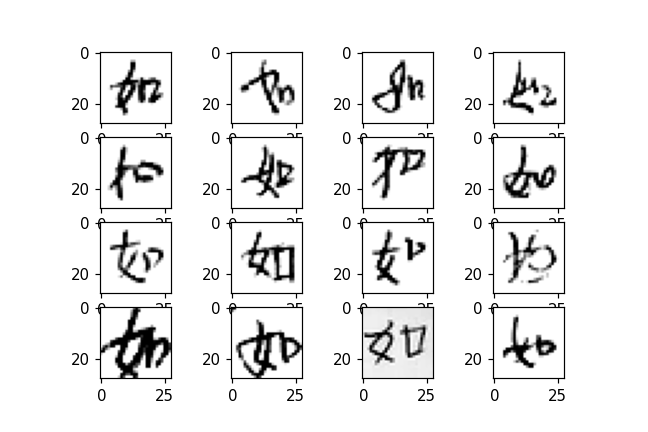

In [17]:
# Displays a few images to verify functionality
x = 4
y = 4
f, axarr = plt.subplots(x,y)

k = 0
ite = len(train_images)/200

for i in range(x):
    for j in range(y):
        axarr[i,j].imshow(train_images[k,:,:],cmap='gray')
        k += 40



x_train = train data <br>
y_train = train labels

x_test = test data <br>
y_test = test labels

# Training the Model (CNN)

In [18]:
train_data = x_train
train_labels = y_train
val_data = x_test
val_labels = y_test


train_data = train_data / 255 # [0, 255] -> [0, 1]
val_data = val_data / 255

In [19]:
"""
This code segment maps an integer to each character.
I did this because softmax_cross_entropy only accepts integer inputs, which works fine for MNIST because their 
values are integers (0-9), but doesn't work when the values are chinese characters (中文汉字), which are strings.
"""


char_map_train = train_labels

all_chars_train = list(set(char_map_train)) # All of the unique characters
print(f"TRAINING:\n\n {all_chars_train} {len(all_chars_train)} unique chars (train)")

conversion_values_train = dict()
for i in range(len(all_chars_train)):
    conversion_values_train[all_chars_train[i]] = i

print(f"{conversion_values_train} train conversions")

train_labels = np.array([conversion_values_train[char] for char in train_labels])
print(f"Train: {char_map_train} maps to {train_labels} \n")

# VALIDATION
char_map_val = val_labels

all_chars_val = list(set(char_map_train)) # All of the unique characters
print(f"\nVALIDATION (TEST):\n\n {all_chars_val} {len(all_chars_val)} unique chars (val)")

conversion_values_val = dict()
for i in range(len(all_chars_val)):
    conversion_values_val[all_chars_val[i]] = i

print(f"{conversion_values_val} val conversions")

val_labels = np.array([conversion_values_val[char] for char in val_labels])
print(f"Val: {char_map_val} maps to {val_labels} \n")


TRAINING:

 ['爪', '毕', '口', '如'] 4 unique chars (train)
{'爪': 0, '毕': 1, '口': 2, '如': 3} train conversions
Train: ['毕' '爪' '毕' ... '如' '毕' '如'] maps to [1 0 1 ... 3 1 3] 


VALIDATION (TEST):

 ['爪', '毕', '口', '如'] 4 unique chars (val)
{'爪': 0, '毕': 1, '口': 2, '如': 3} val conversions
Val: ['如' '口' '毕' ... '口' '毕' '如'] maps to [3 2 1 ... 2 1 3] 



In [20]:
train_data = train_data.reshape(-1, 1, 28, 28)
val_data = val_data.reshape(-1, 1, 28, 28)
train_data.shape, val_data.shape

((15631, 1, 28, 28), (3409, 1, 28, 28))

In [21]:
class Model:
    ''' A simple 5-layer CNN for MNIST. '''
    def __init__(self):
        init = glorot_uniform
        args = {'gain': np.sqrt(2)}
        self.conv1 = conv(1, 16, 3, 3, padding=1, weight_initializer=init, 
                          weight_kwargs=args)
        self.conv2 = conv(16, 16, 3, 3, padding=1, weight_initializer=init, 
                          weight_kwargs=args)
        self.conv3 = conv(16, 32, 3, 3, padding=1, weight_initializer=init, 
                          weight_kwargs=args)
        self.conv4 = conv(32, 32, 3, 3, padding=1, weight_initializer=init, 
                          weight_kwargs=args)
        self.dense = dense(32*7*7, 5) # CHANGE THE LAST VALUE FOR HOW MANY CHARS

    def __call__(self, x):
        ''' Perform a forward pass of the model.
        
        Parameters
        ----------
        x : Union[numpy.ndarray, mygrad.Tensor]
            The data to send through the model.
            
        Returns
        -------
        mygrad.Tensor
            The output of the model (predictions).
        '''
        x = relu(self.conv2(relu(self.conv1(x))))
        x = max_pool(x, (2, 2), 2)
        x = relu(self.conv4(relu(self.conv3(x))))
        x = max_pool(x, (2, 2), 2)
        return self.dense(x.reshape(-1, 32*7*7))
        print(f"{x.shape} = x.shape") # 128 x 32 x 16 x 16 for 64x64, 128 x 32 x 7 x 7 for 28x28
        #return self.dense(x.reshape(-1, 32*16*16))
    
    @property
    def parameters(self):
        ''' Access the parameters of the model.
        
        Returns
        -------
        Tuple[mygrad.Tensor, ...]
            The parameters of the model.
        '''
        params = []
        for layer in (self.conv1, self.conv2, self.conv3, self.conv4, self.dense):
            params += list(layer.parameters)
        return params

In [22]:
m = Model()

In [23]:
optim = SGD(m.parameters, learning_rate=0.001, momentum=0.99)

<IPython.core.display.Javascript object>


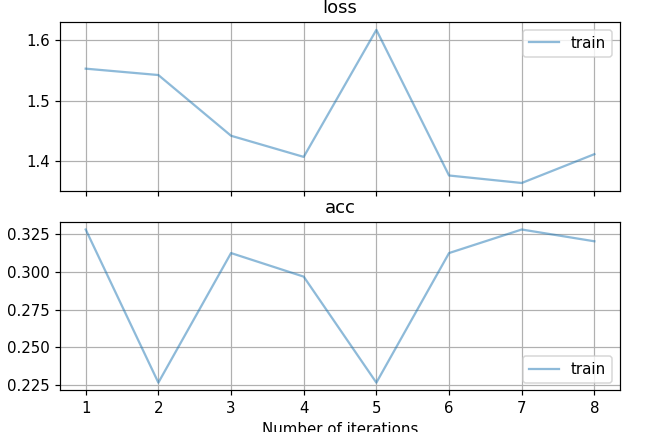

In [24]:
from noggin import create_plot
#plotter, fig, ax = create_plot(["loss", "accuracy"])
plotter, fig, ax = create_plot({'loss', 'acc'}, 0.1)

In [25]:
from ipywidgets import FloatProgress
from IPython.display import display
import time


def train_epoch(batch_size=128):
    ''' Train the model for one epoch. '''
    idxs = np.arange(len(train_data)) # shuffle our data
    np.random.shuffle(idxs)
    print(f"{len(train_data)} len train_data")
    
    # Progress bar for epoch
    max_count = 100
    f = FloatProgress(min=0, max=max_count) # instantiate the bar
    display(f) # display the bar
    
    for batch in range(0, len(idxs), batch_size):
        #print("Batch #", batch, "of", len(idxs), round(100*(batch/len(idxs)), 2), "% Through Epoch") # shows progress
        f.value = 100*(batch/len(idxs)) # Plot on progress bar
        
        data = train_data[idxs[batch:batch+batch_size]]
        targets = train_labels[idxs[batch:batch+batch_size]]
        
        #print(targets.shape, "=targets.shape\n", data.shape, "=data.shape")
        #print(data)
        #print(targets)
        
        outs = m(data)                              # get the model output
        
        #print("len Outs:", len(outs), "len targets:", len(targets))
        #print("outs", outs.shape, "targets", targets.shape)
        loss = softmax_cross_entropy(outs, targets) # compute the loss
        loss.backward()                             # backpropagate the loss
        optim.step()                                # train the model
        loss.null_gradients()                       # clear the gradients

        # plot our training statistics
        correct = (outs.data.argmax(axis=1) == targets).sum()
        plotter.set_train_batch({'loss': loss.data, 'acc': correct / len(outs)}, len(outs))

In [26]:
def evaluate_model(batch_size=256):
    for batch in range(0, len(val_data), batch_size):
        data_batch = val_data[batch:batch + batch_size]
        target_batch = val_labels[batch:batch+batch_size]
        
        outs = m(data_batch)  # get output
        outs.null_gradients() # clear the graph
        
        correct = (outs.data.argmax(axis=1) == target_batch).sum()
        plotter.set_test_batch({'acc': correct / len(outs)}, len(outs))

In [27]:
def evaluate_val(batch_size=256):
    acc = []
    for batch in range(0, len(val_data), batch_size):
        data_batch = val_data[batch:batch + batch_size]
        target_batch = val_labels[batch:batch+batch_size]

        outs = m(data_batch)  # get output

        correct = (outs.data.argmax(axis=1) == target_batch).sum()
        if len(outs) == 256:
            acc.append(correct / len(outs))
    print(f"Test Data: {sum(acc)/len(acc)}")
    return sum(acc)/len(acc)

In [28]:
from datetime import datetime as dt

test_res = []
for epoch in range(2):
    print(f"EPOCH {epoch+1}")
    start_epoch = dt.now()
    print(start_epoch)
    
    train_epoch()
    test_res.append(evaluate_val())
    #plotter.plot()
    print(f"Epoch took: {dt.now()-start_epoch} \n\n")
print(test_res)

EPOCH 1
2022-05-23 10:50:57.696616
15631 len train_data


FloatProgress(value=0.0)

C:\Users\nrabi\anaconda3\envs\charidentify\lib\site-packages\mygrad\tensor_base.py:1436: FutureWarning: `tensor.null_gradients()` is deprecated. Calling it will raise an error in future versions of MyGrad. A tensor will automatically have its gradient nulled if you use it in a new computational graph. Or, you can call `tensor.null_grad()` to null that individual tensor's gradient.
  warnings.warn(


KeyboardInterrupt: 

In [29]:
print(conversion_values_train)

{'爪': 0, '毕': 1, '口': 2, '如': 3}


In [30]:
def evaluate_val2(batch_size=256):
    acc = []

    conversion_values = dict((v,k) for k,v in conversion_values_train.items())
    print(conversion_values)
    
    chars = conversion_values_train.copy()
    for key in chars:
        chars[key] = 0
    print(chars)
    
    chars2 = conversion_values_train.copy()
    for key in chars2:
        chars2[key] = 0
    print(chars2)
    
    chars3 = conversion_values_train.copy()
    for key in chars3:
        chars3[key] = 0
    print(chars3)
    
    print(f"{len(val_data)} val_data len")

    for batch in range(0, len(val_data), batch_size):
        data_batch = val_data[batch:batch + batch_size]
        target_batch = val_labels[batch:batch+batch_size]
        #print(conversion_values_train)
        #print("Target Batch = ", [conversion_values[x] for x in target_batch], "\n\n")
        outs = m(data_batch)  # get output
        #outs.null_gradients() # clear the graph
        
        #print("Model Batch = ", [conversion_values[x] for x in outs.data.argmax(axis=1)])
        
        for i in range(len(target_batch)):
            #print("actual", conversion_values[target_batch[i]], "= model:", conversion_values[outs.data.argmax(axis=1)[i]])
            if conversion_values[target_batch[i]] == conversion_values[outs.data.argmax(axis=1)[i]]:
                #print("correct")
                #print(conversion_values[target_batch[i]], "L")
                chars[conversion_values[target_batch[i]]] += 1
            else:
                #print("incorrect")
                chars2[conversion_values[outs.data.argmax(axis=1)[i]]] += 1
            
            chars3[conversion_values[outs.data.argmax(axis=1)[i]]] += 1
        
        correct = (outs.data.argmax(axis=1) == target_batch).sum()
        #print('acc', correct / len(outs), len(outs), "")
        if len(outs) == 256:
            acc.append(correct / len(outs))
    #print("done")
    print(f"Test Data: {sum(acc)/len(acc)}")
    print(f"{chars} successfully identified")
    print(f"{chars2} misidentified as")
    print(f"{chars3} total number of times each character was identified by model (right or wrong)")
    return sum(acc)/len(acc)

In [256]:
evaluate_val2()

{0: '毕', 1: '爪', 2: '口', 3: '如'}
{'毕': 0, '爪': 0, '口': 0, '如': 0}
{'毕': 0, '爪': 0, '口': 0, '如': 0}
{'毕': 0, '爪': 0, '口': 0, '如': 0}
3409 val_data len
Test Data: 0.27944711538461536
{'毕': 299, '爪': 281, '口': 48, '如': 317} successfully identified
{'毕': 690, '爪': 739, '口': 368, '如': 667} misidentified as
{'毕': 989, '爪': 1020, '口': 416, '如': 984} total number of times each character was identified by model (right or wrong)


0.27944711538461536

In [ ]:
def evaluate_train(batch_size=256):
    acc = []
    for batch in range(0, len(train_data), batch_size):
        data_batch = train_data[batch:batch + batch_size]
        target_batch = train_labels[batch:batch+batch_size]
        
        outs = m(data_batch)  # get output
        
        correct = (outs.data.argmax(axis=1) == target_batch).sum()
        print(f"acc {correct / len(outs)} {len(outs)}")
        if len(outs) == 256:
            acc.append(correct / len(outs))
    print("done")
    print(f"Overall: {sum(acc)/len(acc)}")

In [ ]:
evaluate_train()